In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import string
import theano
import therapy
import importlib
import itertools
import scipy.stats

sns.set()
plt.ion()

idx = pd.IndexSlice

# 8 Markov Chain Monte Carlo

## 8.1. Good King Markov and His island kingdom

In [87]:
# Code 8.1
rs = np.random.RandomState(seed=42)
num_weeks = 100000

positions = np.zeros(num_weeks, dtype=int)

current = 10

for i in range(len(positions)):
    # record current position
    positions[i] = current

    # flip coin to generate a proposal
    proposal = current + rs.choice([-1, 1])

    # now make sure he loops around the archipelago
    if proposal < 1:
        proposal = 10

    if proposal > 10:
        proposal = 1

    # move?
    prob_move = proposal / current

    current = proposal if rs.uniform() < prob_move else current

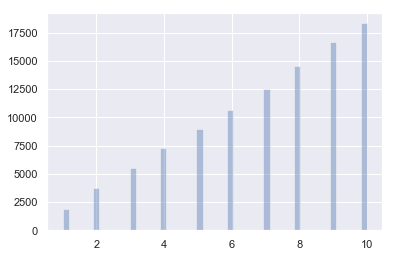

In [90]:
sns.distplot(positions, kde=False)

# change of pace
from here on will only do exercises

## 8.6 Practice

**Easy**

### 8E1.

(1) No, samples may also be continuous

(2) Unsure what 'likelihood function' means in this specific case. If it means likelihood function of data given hypothesis, then no, this is not a requirement either.

(3) Yes, the proposal distribution must be symmetric

### 8E2.
Gibbs sampling is more efficient, i.e. can generate an image of the posterior that is just as good as the simple Metropolis algorithm in fewer samples, by allowing for an asymmetrical proposal distribution, and by using adaptive proposals. The distribution of proposes parameters then depends on current parameter values through using conjugate prior/likelihood combinations. These conjugate pairs have analytical solutions for posterior distributions of individual parameters, which can be used to make more efficient jumps around the joint posterior of all parameters.

On the flipside, Gibbs sampling only works for conjugate pairs, even though these combinations of prior and likelihood might not make the most sense for a model. Furthermore, Gibbs sampling can become very inefficient for large models with many parameters

### 8E3.
Hamiltonian Monte Carlo can only handle continuous parameters, as it essentially simulates a frictionless particle gliding over parameter space. It can't glide over non-continuous space. As a consequence, it can't be used in some scenarios, e.g. imputation of discrete missing data.

### 8E4.
n_eff is an estimate of the number of independent samples. I'm not sure how that differs from the actual number of samples. My guess is that only independent samples really tell us something about the posterior?

### 8E5.
Rhat should approach 1 from above if a chain is sampling the posterior correctly.

### 8E6.
Looking for stationarity and good mixing. Stationarity: path stays within posterior. Mean value of chain stable beggining to end. Well-mixing: consecutive values not highly correlated. Visually indicated by rapid zig-zagging.


[good plot]
[bad plot]

**Medium**

### 8M1.

In [2]:
d = (
    pd
    .read_csv('./data/rugged.csv', sep=';')
    .set_index('isocode')
    .assign(log_gdp=lambda df: np.log(df['rgdppc_2000']))
)

d.head()

,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,lon,...,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent,log_gdp
isocode,,,,,,,,,,,,,,,,,,,,,
ABW,533,Aruba,0.462,0.380,1.226,0.144,0.000,18.0,12.508,-69.970,...,0,0,0.0,NaN,NaN,NaN,NaN,614.0,NaN,NaN
AFG,4,Afghanistan,2.518,1.469,7.414,0.720,39.004,65209.0,33.833,66.026,...,0,0,0.0,NaN,NaN,NaN,NaN,1870829.0,0.0,NaN
AGO,24,Angola,0.858,0.714,2.274,0.228,4.906,124670.0,-12.299,17.551,...,0,1,3610000.0,5.669,6.981,4.926,3.872,1223208.0,2.0,7.492609
AIA,660,Anguilla,0.013,0.010,0.026,0.006,0.000,9.0,18.231,-63.064,...,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALB,8,Albania,3.427,1.597,10.451,1.006,62.133,2740.0,41.143,20.070,...,0,0,0.0,NaN,NaN,NaN,NaN,200000.0,100.0,8.216929


In [3]:
d.shape

(234, 51)

In [4]:
dd = d.dropna(subset=["rgdppc_2000"])

In [5]:
dd.shape

(170, 51)

In [55]:
with pm.Model() as m:
    data = dd
    shared = therapy.create_theano_shared_from_df(data)
    pm.HalfCauchy('sigma', 2)
    pm.Normal('bAR', 0, 10)
    pm.Normal('bA', 0, 10)
    pm.Normal('bR', 0, 10)
    pm.Normal('a', 0, 100)
    pm.Deterministic(
        'mu', 
        m.a 
        + m.bR * shared['rugged'] 
        + m.bA * shared['cont_africa']
        + m.bAR * shared['cont_africa'] * shared['rugged']
    )
    pm.Normal('log_gdp', m.mu, m.sigma, observed=shared['log_gdp'])

m_8_1 = therapy.Model(m, shared, 'm_8_1')

m_8_1.fit()

therapy.interesting_summary(m_8_1).sort_index()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 557.94draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,9.226120,0.141728,0.006971,8.920120,9.481871,375.905557,0.999277
bA,-1.954303,0.216797,0.010523,-2.422787,-1.557999,418.134250,0.999910
bAR,0.398612,0.121295,0.005775,0.146390,0.628339,458.882804,0.999887
bR,-0.206232,0.078177,0.003703,-0.353199,-0.057766,425.742208,0.999258
sigma,0.952154,0.050568,0.001814,0.861035,1.057677,742.128092,0.999550


In [61]:
with pm.Model() as m:
    data = dd
    shared = therapy.create_theano_shared_from_df(data)
    pm.Uniform('sigma', 0, 10)
    pm.Normal('bAR', 0, 10)
    pm.Normal('bA', 0, 10)
    pm.Normal('bR', 0, 10)
    pm.Normal('a', 0, 100)
    pm.Deterministic(
        'mu', 
        m.a 
        + m.bR * shared['rugged'] 
        + m.bA * shared['cont_africa']
        + m.bAR * shared['cont_africa'] * shared['rugged']
    )
    pm.Normal('log_gdp', m.mu, m.sigma, observed=shared['log_gdp'])

m_8m1unif = therapy.Model(m, shared, 'm_8m1unif')

m_8m1unif.fit()

therapy.interesting_summary(m_8m1unif).sort_index()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:04<00:00, 472.68draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,9.228150,0.145182,0.006763,8.948083,9.500981,394.380268,1.002030
bA,-1.957342,0.224348,0.009816,-2.404717,-1.538572,427.674135,0.999608
bAR,0.395113,0.131633,0.005846,0.136900,0.651283,407.909690,1.001617
bR,-0.202744,0.079375,0.003624,-0.367422,-0.064187,400.881606,1.004477
sigma,0.949854,0.053220,0.001862,0.849570,1.065048,911.260267,0.999000


In [60]:
with pm.Model() as m:
    data = dd
    shared = therapy.create_theano_shared_from_df(data)
    pm.Exponential('sigma', 1)
    pm.Normal('bAR', 0, 10)
    pm.Normal('bA', 0, 10)
    pm.Normal('bR', 0, 10)
    pm.Normal('a', 0, 100)
    pm.Deterministic(
        'mu', 
        m.a 
        + m.bR * shared['rugged'] 
        + m.bA * shared['cont_africa']
        + m.bAR * shared['cont_africa'] * shared['rugged']
    )
    pm.Normal('log_gdp', m.mu, m.sigma, observed=shared['log_gdp'])

m_8m1exp = therapy.Model(m, shared, 'm_8m1exp')

m_8m1exp.fit()

therapy.interesting_summary(m_8m1exp).sort_index()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:04<00:00, 405.55draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,9.221115,0.144071,0.007104,8.955179,9.495077,386.056829,0.999109
bA,-1.947529,0.226487,0.012278,-2.408975,-1.520156,313.535998,0.999457
bAR,0.391621,0.136015,0.007008,0.134606,0.652506,360.705388,0.999019
bR,-0.201967,0.076968,0.003828,-0.339865,-0.040557,381.029686,0.999364
sigma,0.947332,0.053940,0.001921,0.834948,1.049468,725.615374,1.003287


so are inferences actually any different?

In [62]:
models = [m_8_1, m_8m1exp, m_8m1unif]

In [64]:
summaries = [therapy.interesting_summary(m) for m in models]
joined = pd.concat(summaries, keys=[m.name for m in models])
joined

In [99]:
sliced = joined.loc[idx[:, 'sigma'], :]
sliced

In [132]:
yerr = np.abs(sliced['mean'].values[:, np.newaxis] - sliced[['hpd_2.5', 'hpd_97.5']].values).T
sns.barplot(x=sliced.index, y='mean', data=sliced)
plt.errorbar(x=range(len(sliced)), y='mean', yerr=yerr, data=sliced, fmt='none');

doesn't look like there's any measurable difference

### 8M2.

investigate of making half cauchy prior stronger

In [136]:
scaling_vals = np.linspace(0.1, 2, 5)

In [260]:
def train_8m2(sv, kind):
    if kind == 'cauchy':
        sigma_prior = pm.HalfCauchy
    elif kind == 'exp':
        sigma_prior = pm.Exponential
    else:
        raise ValueError('"kind" must be "cauchy" or "exp"')
        
    with pm.Model() as m:
        data = dd
        shared = therapy.create_theano_shared_from_df(data)
        sigma_prior('sigma', sv)
        pm.Normal('bAR', 0, 10)
        pm.Normal('bA', 0, 10)
        pm.Normal('bR', 0, 10)
        pm.Normal('a', 0, 100)
        pm.Deterministic(
            'mu', 
            m.a 
            + m.bR * shared['rugged'] 
            + m.bA * shared['cont_africa']
            + m.bAR * shared['cont_africa'] * shared['rugged']
        )
        pm.Normal('log_gdp', m.mu, m.sigma, observed=shared['log_gdp'])

    m_8m2 = therapy.Model(m, shared, f'm_8m2{kind}_{sv}')
    m_8m2.fit(progressbar=False)
    
    return m_8m2

#### cauchy

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
The acceptance probability does not match the target. It is 0.9366451925730707, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8789189525240709, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
The acceptance probability does not match the target. It is 0.8791862500881877, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
The acceptance probability does not match the target. It is 0.891974693287046, but should be clos

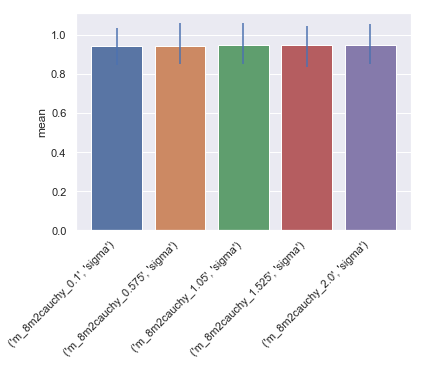

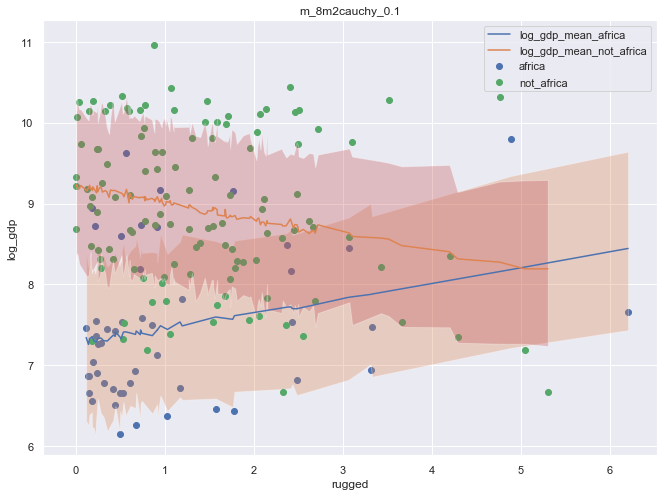

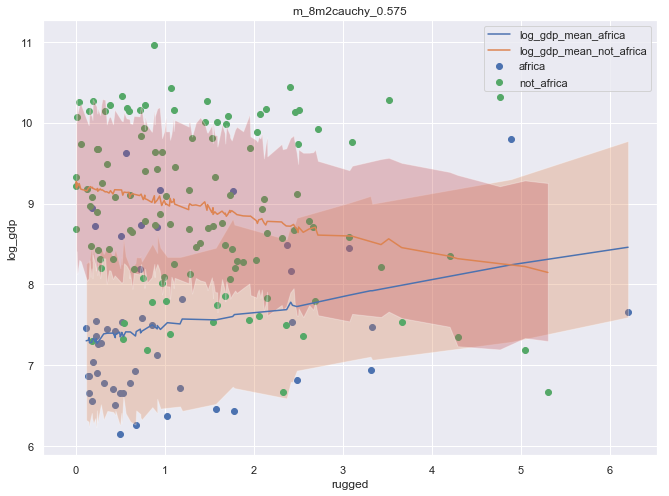

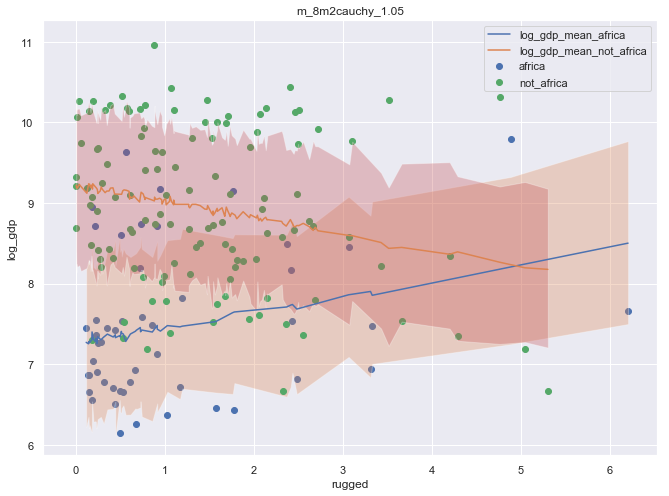

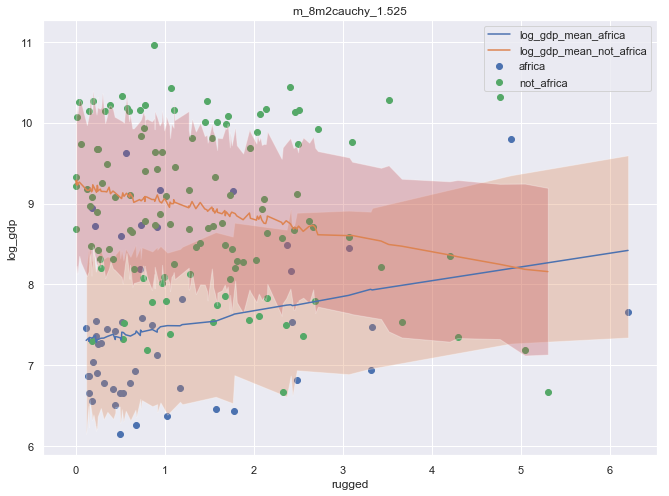

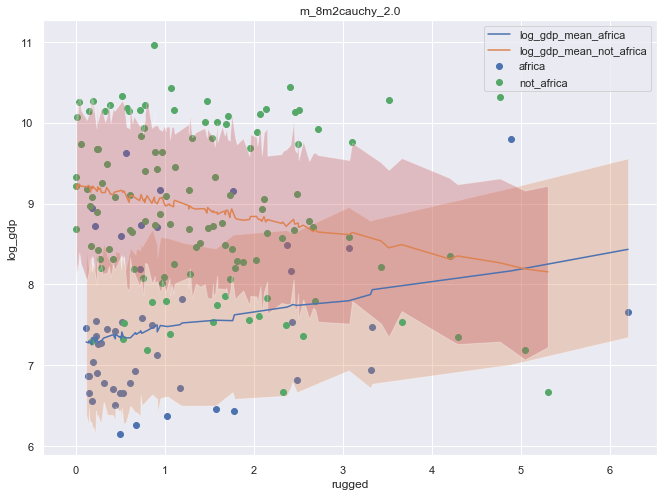

In [267]:
cauchy_models = [train_8m2(sv, 'cauchy') for sv in scaling_vals]

summaries = [therapy.interesting_summary(m) for m in cauchy_models]
joined = pd.concat(summaries, keys=[m.name for m in cauchy_models])
sliced = joined.loc[idx[:, 'sigma'], :]

yerr = np.abs(sliced['mean'].values[:, np.newaxis] - sliced[['hpd_2.5', 'hpd_97.5']].values).T
sns.barplot(x=sliced.index, y='mean', data=sliced)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.errorbar(x=range(len(sliced)), y='mean', yerr=yerr, data=sliced, fmt='none');

cauchy_samples = [cm.predict() for cm in cauchy_models]

for cm, samples in zip(cauchy_models, cauchy_samples): 

    samples_data = (
        samples
        .set_index(dd.index)
        .join(dd)
    )

    samples_data_sorted = samples_data.sort_values('rugged', ascending=True)
    mask = samples_data_sorted.cont_africa == 1
    af = samples_data_sorted[mask]
    naf = samples_data_sorted[~mask]

    plt.figure()
    for df, name in zip([af, naf], ['africa', 'not_africa']):
        plt.scatter(x='rugged', y='log_gdp', data=df, label=name)
        plt.plot('rugged', 'log_gdp_mean', data=df, label=f'log_gdp_mean_{name}')
        plt.fill_between(x='rugged', y1='log_gdp_hpd_lower', y2='log_gdp_hpd_upper', data=df, alpha=.3)

    plt.xlabel('rugged')
    plt.ylabel('log_gdp')
    plt.legend()
    plt.title(cm.name)
    plt.gcf().set_size_inches(11,8)

can't really see any difference. try plotting all five lines+uncertainty for cont_africa == {0/1} in one plot to see it more clearly?

#### exponential

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
The acceptance probability does not match the target. It is 0.8834120429401278, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8847218980912737, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
The acceptance probability does not match the target. It is 0.8819054067049806, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling

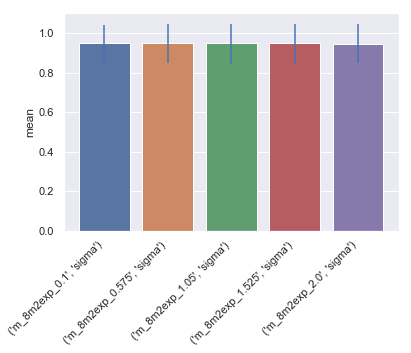

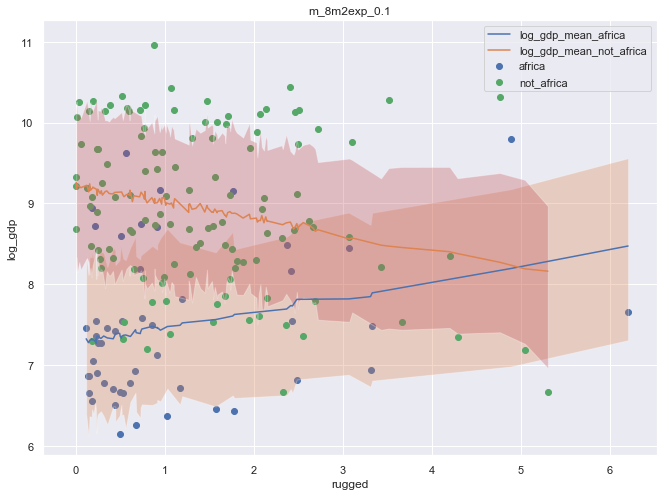

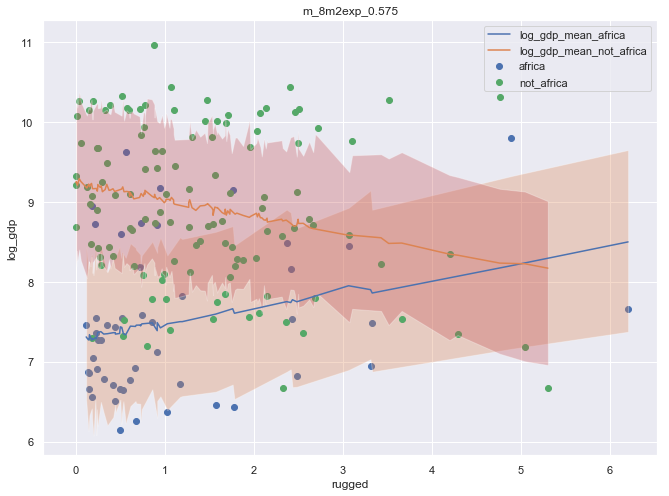

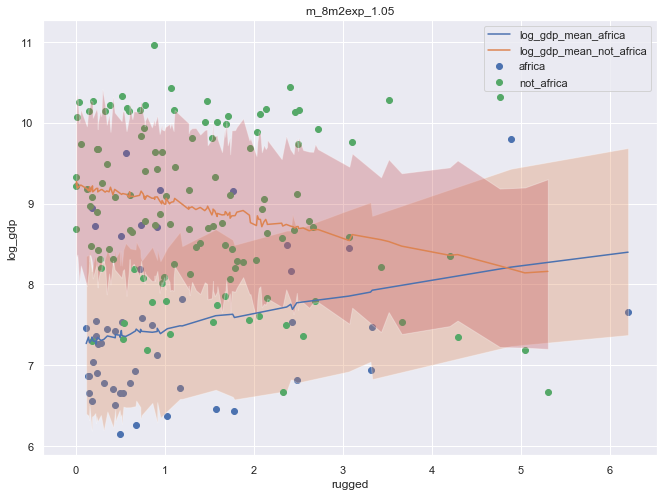

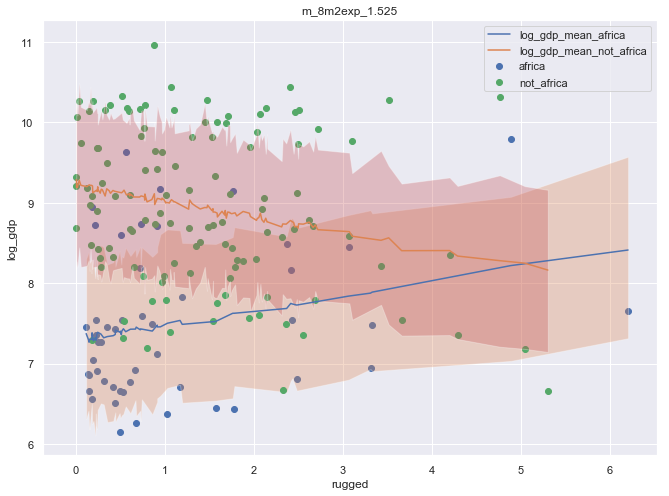

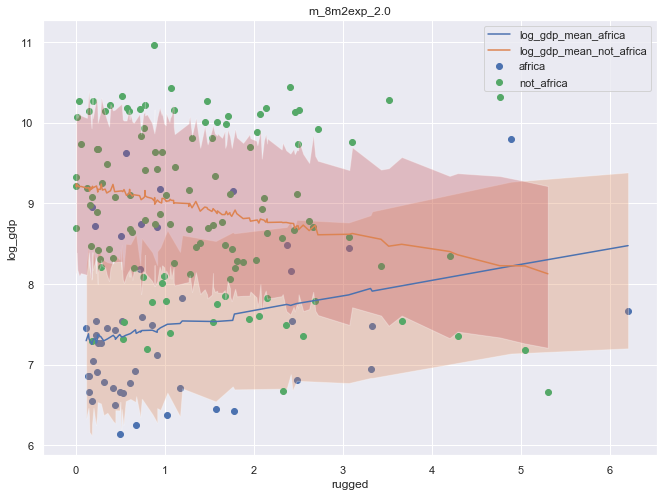

In [266]:
exp_models = [train_8m2(sv, 'exp') for sv in scaling_vals]

summaries = [therapy.interesting_summary(m) for m in exp_models]
joined = pd.concat(summaries, keys=[m.name for m in exp_models])
sliced = joined.loc[idx[:, 'sigma'], :]

yerr = np.abs(sliced['mean'].values[:, np.newaxis] - sliced[['hpd_2.5', 'hpd_97.5']].values).T

plt.figure()
sns.barplot(x=sliced.index, y='mean', data=sliced)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.errorbar(x=range(len(sliced)), y='mean', yerr=yerr, data=sliced, fmt='none');

exp_samples = [cm.predict() for cm in exp_models]

for cm, samples in zip(exp_models, exp_samples): 

    samples_data = (
        samples
        .set_index(dd.index)
        .join(dd)
    )

    samples_data_sorted = samples_data.sort_values('rugged', ascending=True)
    mask = samples_data_sorted.cont_africa == 1
    af = samples_data_sorted[mask]
    naf = samples_data_sorted[~mask]

    plt.figure()
    for df, name in zip([af, naf], ['africa', 'not_africa']):
        plt.scatter(x='rugged', y='log_gdp', data=df, label=name)
        plt.plot('rugged', 'log_gdp_mean', data=df, label=f'log_gdp_mean_{name}')
        plt.fill_between(x='rugged', y1='log_gdp_hpd_lower', y2='log_gdp_hpd_upper', data=df, alpha=.3)

    plt.xlabel('rugged')
    plt.ylabel('log_gdp')
    plt.legend()
    plt.title(cm.name)
    plt.gcf().set_size_inches(11,8)

nothing seems to change? maybe there's just so much data that the prior doesn't matter?

### 8M3

assuming 'the stan model from the chapter' refers to m8.1stan

In [53]:
def train_8m3(n_tune):
    with pm.Model() as m:
        data = dd
        shared = therapy.create_theano_shared_from_df(data)
        pm.HalfCauchy('sigma', 2)
        pm.Normal('bAR', 0, 10)
        pm.Normal('bA', 0, 10)
        pm.Normal('bR', 0, 10)
        pm.Normal('a', 0, 100)
        pm.Deterministic(
            'mu', 
            m.a 
            + m.bR * shared['rugged'] 
            + m.bA * shared['cont_africa']
            + m.bAR * shared['cont_africa'] * shared['rugged']
        )
        pm.Normal('log_gdp', m.mu, m.sigma, observed=shared['log_gdp'])

    m_8m3 = therapy.Model(m, shared, f'm_8m3_tune_{n_tune}')

    m_8m3.fit(tune=n_tune, draws=1000, progressbar=False, random_seed=42)
    
    return m_8m3

In [54]:
n_tune_vals = [1, 25, 50, 75, 100, 250, 500, 1000, 2000]

In [55]:
tune_models = [train_8m3(n) for n in n_tune_vals]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acc

In [56]:
tune_summaries = [therapy.interesting_summary(m).sort_index() for m in tune_models]

In [57]:
tune_joined = pd.concat(tune_summaries, keys=[n for n in n_tune_vals], names=['n_tune', 'metric'])

In [58]:
tune_joined.head()

mean        sd  mc_error   hpd_2.5  hpd_97.5   n_eff  \
n_tune metric                                                             
1      a       0.488839  0.391979  0.039198  0.096860  0.880817     NaN   
       bA     -0.626498  0.227600  0.022760 -0.854098 -0.398897  1.0005   
       bAR     0.568713  0.007656  0.000766  0.561057  0.576369  1.0005   
       bR     -0.932508  0.043634  0.004363 -0.976142 -0.888874     NaN   
       sigma   1.653085  0.090529  0.009053  1.562556  1.743614  1.0005   

                       Rhat  
n_tune metric                
1      a       7.057728e+15  
       bA      1.832695e+15  
       bAR     9.747527e+13  
       bR      2.618823e+14  
       sigma   2.260412e+14

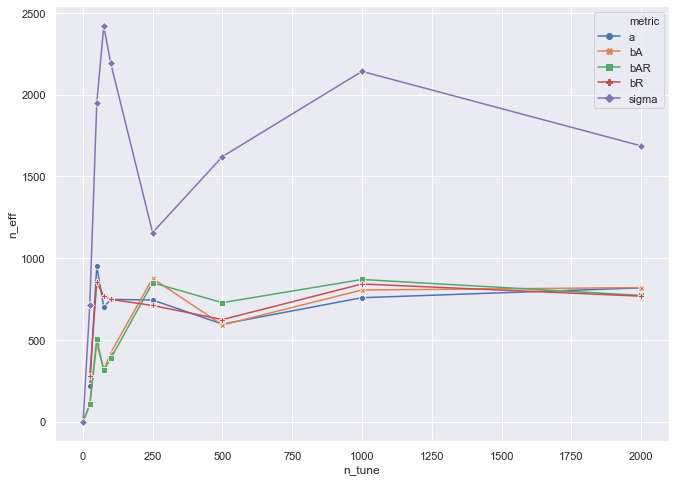

In [63]:
sns.lineplot(
    x='n_tune', 
    y='n_eff', 
    hue='metric', 
    style='metric', 
    markers=True, 
    dashes=False, 
    data=tune_joined.reset_index()
)
plt.gcf().set_size_inches(11,8)

not a lot of difference past 250 tuning iterations

**Hard.**

### 8H1.

In [76]:
# Code 8.20

with pm.Model() as m:
    pm.Normal('a', 0, 1)
    pm.Cauchy('b', 0, 1)
    
m_8h1 = therapy.Model(m, None, f'm_8h1')
m_8h1.fit(tune=100, draws=10000, progressbar=False, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
The acceptance probability does not match the target. It is 0.9003855624169312, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


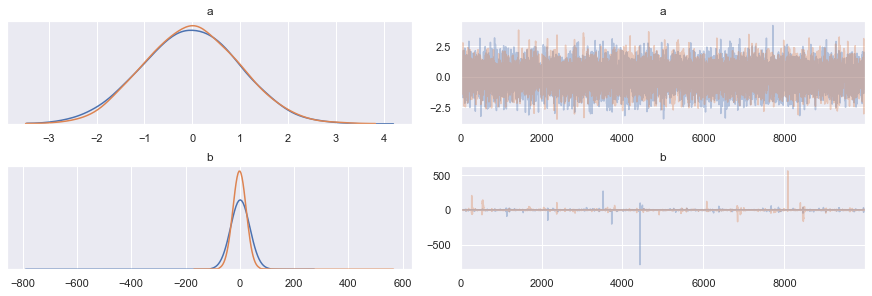

In [77]:
pm.traceplot(m_8h1.trace);

In [78]:
therapy.interesting_summary(m_8h1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,-0.015425,0.998088,0.011205,-1.901944,1.975953,7632.522559,1.000285
b,0.035158,16.151126,0.270837,-10.532974,10.442897,3125.856018,1.000104


Trace for the the Cauchy distribution of 'b' look abnormal. Chains do not agree, no good mixing/stationarity. Reason: Cauchy fat-tailed, always reasonable probability of drawing very large value which overwhelms rest of samples. Thus no defined mean/variance, and also thus different shapes in chains and huge outlier values visible in trace plot.

In [79]:
samples = pm.trace_to_dataframe(m_8h1.trace)

In [81]:
samples.head()

,a,b
0,1.109347,-1.071596
1,-0.190990,-0.809110
2,-1.111653,9.711530
3,0.288297,7.406505
4,0.229748,7.917402


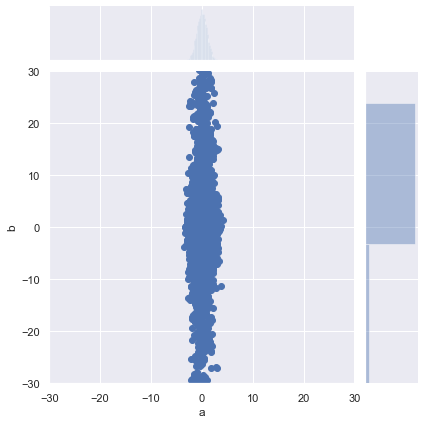

In [93]:
sns.jointplot(x='a', y='b', data=samples, kind='scatter', xlim=(-30, 30), ylim=(-30, 30))

### 8H2.

In [105]:
d = (
    pd
    .read_csv('./data/WaffleDivorce.csv', sep=';')
    .set_index('Location')
    .assign(
        MedianAgeMarriage_s=lambda df: scipy.stats.zscore(df.MedianAgeMarriage),
        Marriage_s=lambda df: scipy.stats.zscore(df.Marriage)
    )
)

d.head()

,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,MedianAgeMarriage_s,Marriage_s
Location,,,,,,,,,,,,,,
Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.612445,0.022874
Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,-0.693671,1.565536
Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,-0.206314,0.049472
Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,-1.424706,1.671927
California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,0.605947,-0.269700


In [218]:
with pm.Model() as m:
    shared = therapy.create_theano_shared_from_df(d)
    
    pm.Uniform('sigma', 0, 10)
    pm.Normal('bA', 0, 1)
    pm.Normal('a', 10, 10)
    pm.Deterministic(
        'mu',
        m.a
        + m.bA * shared['MedianAgeMarriage_s']
    )
    pm.Normal('Divorce', m.mu, m.sigma, observed=shared['Divorce'])
    
    
m_8h2_5m1 = therapy.Model(m, shared, f'm_8h2_5m1')
m_8h2_5m1.fit(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, sigma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 871.51draws/s] 


In [219]:
with pm.Model() as m:
    shared = therapy.create_theano_shared_from_df(d)
    
    pm.Uniform('sigma', 0, 10)
    pm.Normal('bR', 0, 1)
    pm.Normal('a', 10, 10)
    pm.Deterministic(
        'mu',
        m.a
        + m.bR * shared['Marriage_s']
    )
    pm.Normal('Divorce', m.mu, m.sigma, observed=shared['Divorce'])
    
    
m_8h2_5m2 = therapy.Model(m, shared, f'm_8h2_5m2')
m_8h2_5m2.fit(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, sigma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 873.42draws/s] 


In [220]:
with pm.Model() as m:
    shared = therapy.create_theano_shared_from_df(d)
    
    pm.Uniform('sigma', 0, 10)
    pm.Normal('bA', 0, 1)
    pm.Normal('bR', 0, 1)
    pm.Normal('a', 10, 10)
    pm.Deterministic(
        'mu',
        m.a
        + m.bA * shared['MedianAgeMarriage_s']
        + m.bR * shared['Marriage_s']
    )
    pm.Normal('Divorce', m.mu, m.sigma, observed=shared['Divorce'])
    
    
m_8h2_5m3 = therapy.Model(m, shared, f'm_8h2_5m3')
m_8h2_5m3.fit(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, sigma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 802.14draws/s] 


100%|██████████| 1000/1000 [00:00<00:00, 1775.57it/s]


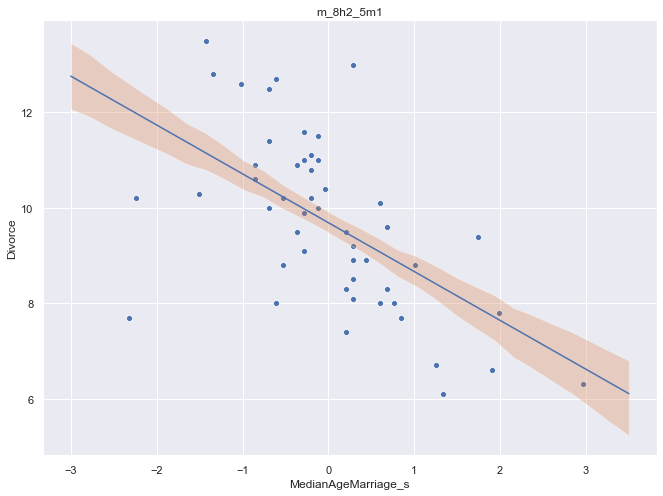

In [300]:
# based on R code 5.2
mam_seq = np.linspace(-3, 3.5, 30)

mu = m_8h2_5m1.predict(
    pd.DataFrame({'MedianAgeMarriage_s': mam_seq}),
    sample_ppc_kwargs={'var_names': ['mu']}
)
xy = mu.assign(MedianAgeMarriage_s=mam_seq)

ax = sns.scatterplot(x='MedianAgeMarriage_s', y='Divorce', data=d);
ax.plot('MedianAgeMarriage_s', 'mu_mean', data=xy);
ax.fill_between('MedianAgeMarriage_s', 'mu_hpd_lower', 'mu_hpd_upper', alpha=.3, data=xy);
plt.title(m_8h2_5m1.name)
f = plt.gcf().set_size_inches(11,8)

In [301]:
d.Marriage_s.min()

-1.7591667404919278

In [302]:
d.Marriage_s.max()

2.815624299190736

100%|██████████| 1000/1000 [00:00<00:00, 2399.99it/s]


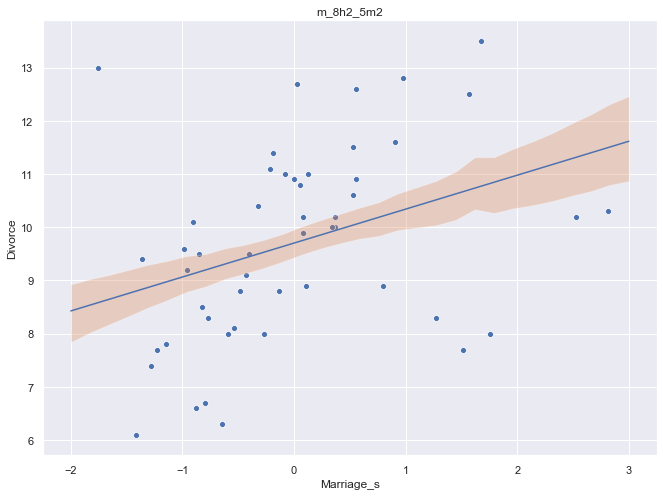

In [307]:
m_seq = np.linspace(-2, 3, 30)

mu = m_8h2_5m2.predict(
    pd.DataFrame({'Marriage_s': m_seq}),
    sample_ppc_kwargs={'var_names': ['mu']}
)
xy = mu.assign(Marriage_s=m_seq)

ax = sns.scatterplot(x='Marriage_s', y='Divorce', data=d);
ax.plot('Marriage_s', 'mu_mean', data=xy);
ax.fill_between('Marriage_s', 'mu_hpd_lower', 'mu_hpd_upper', alpha=.3, data=xy);
plt.title(m_8h2_5m2.name)
f = plt.gcf().set_size_inches(11,8)

In [309]:
therapy.compare([m_8h2_5m1, m_8h2_5m2, m_8h2_5m3])

/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m_8h2_5m1,186.46,3.91,0,0.64,11.88,0,1
m_8h2_5m3,188.11,4.9,1.64,0.29,11.8,0.89,1
m_8h2_5m2,200.03,3.28,13.57,0.07,9.65,8.98,1


In [312]:
models = [m_8h2_5m1, m_8h2_5m2, m_8h2_5m3]

In [313]:
    model_names = pd.Series([fm.name for fm in models])

    model_dict = {fm.model: fm.trace for fm in models}


In [314]:
model_names

0    m_8h2_5m1
1    m_8h2_5m2
2    m_8h2_5m3
dtype: object

In [315]:
model_dict

{<pymc3.model.Model at 0x1c2e4c4828>: <MultiTrace: 2 chains, 500 iterations, 5 variables>,
 <pymc3.model.Model at 0x1c35919470>: <MultiTrace: 2 chains, 500 iterations, 5 variables>,
 <pymc3.model.Model at 0x1c302f8940>: <MultiTrace: 2 chains, 500 iterations, 6 variables>}

In [320]:
cmp = (
    pm
    .compare(
        model_dict=model_dict,
        method='BB-pseudo-BMA'
    )
    .assign(model= model_names)
#     .set_index('model')
#     .sort_values('WAIC')
)
cmp

/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn,model
0,186.46,3.91,0,0.63,12.83,0,1,m_8h2_5m1
2,188.11,4.9,1.64,0.29,12.71,0.89,1,m_8h2_5m3
1,200.03,3.28,13.57,0.08,9.84,8.98,1,m_8h2_5m2


In [321]:
pm.compare??